The code to run the experiments we highlighted in our project can be found here.

To begin are some functions to help run Looptree simulations without having to manually change an endless amount of configuration files. 

For some of the Global Buffer experiments you have to change the configs manually. 

In [7]:
from runner import run_experiment
from pytimeloop.looptree.run import run_looptree
from util import *

def make_spatial_dims(mesh, *, E1, B3, H3):
    mx, my = mesh
    return {
        "B3": B3,  "H3": H3,
        "E1": E1,  "P1": my,
        "F3": E1,  "P3": my,
    }

def run_experiments(PE_MESH_SIZES, M3_VALUES, B3_VALS, H3_VALS):
    bindings = {0:"MainMemory",      1:"GlobalBuffer",
                2:"PEWeightStorage", 3:"MACC"}
    
    EXPERIMENTS = {
        "sequential": dict(
            config_dir = CONFIG_DIR / "current" / "sequential",
            mapping    = "mapping_m_tiled.yaml",
            E1_rule    = lambda mx: mx,        # full mesh
        ),
        "pipeline": dict(
            config_dir = CONFIG_DIR / "current" / "pipeline",
            mapping    = "mapping.yaml",
            E1_rule    = lambda mx: mx // 2,   # half mesh
        ),
    }
    
    all_results = {}
    
    for mode, cfg in EXPERIMENTS.items():        
        print(f"\n=== {mode.upper()} ===")
        for mesh in PE_MESH_SIZES:
            print(f"\n→ PE mesh: {mesh}")
            mx, _ = mesh
        
            mode_res = all_results.setdefault(mode, {})
        
            for M in M3_VALUES:                       
                for B3 in B3_VALS:                  
                    for H3 in H3_VALS:             
        
                        spatial = make_spatial_dims(
                            mesh,
                            E1 = cfg["E1_rule"](mx),
                            B3 = B3,
                            H3 = H3
                        )
        
                        key = (mesh, M, B3, H3)
                        print(f"mesh={mesh}  M={M:<3}  B3={B3:<2}  H3={H3:<2}")
        
                        res = run_experiment(
                            pe_mesh        = mesh,
                            temporal_dims  = spatial,
                            m_values       = [M],
                            config_dr      = str(cfg["config_dir"]),
                            arch_yaml      = "architecture.yaml",
                            mapping_yaml   = cfg["mapping"],
                            tmp_dir        = str(TMP_DIR),
                            bindings       = bindings,
                            print_energy_bd=False,
                            print_mem_lat  =False,
                            print_res      =True,
                        )
                        mode_res[key] = res
    return all_results


In [3]:
import matplotlib.pyplot as plt
import math

def plot_latency(results, m_target, b3_target, h3_target):
    lat_seq  = {}    
    lat_pipe = {}
    
    for (mesh, M, B3, H3), res in results["sequential"].items():
        if (M, B3, H3) == (m_target, b3_target, h3_target):
            lat_seq[mesh] = res[M]["latency"]
    
    for (mesh, M, B3, H3), res in results["pipeline"].items():
        if (M, B3, H3) == (m_target, b3_target, h3_target):
            lat_pipe[mesh] = res[M]["latency"]
    
    meshes = sorted(
        set(lat_seq) | set(lat_pipe),
        key=lambda m: m[0] * m[1]
    )
    
    pe_counts   = [mx * my for (mx, my) in meshes]
    lat_seq_lst = [lat_seq.get(mesh,  math.nan) for mesh in meshes]
    lat_pipe_lst= [lat_pipe.get(mesh, math.nan) for mesh in meshes]
    
    plt.figure()
    plt.plot(pe_counts, lat_seq_lst,  marker='o', label='Sequential')
    plt.plot(pe_counts, lat_pipe_lst, marker='s', label='Pipeline')
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.xlabel('Total number of PEs (meshX × meshY)')
    plt.ylabel('Latency (cycles)')
    plt.title(f'Latency vs PE-count  (M={m_target}, B3={b3_target}, H3={h3_target})')
    plt.grid(True, which='both', ls=':')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("Sequential latencies :", lat_seq_lst)
    print("Pipeline latencies   :", lat_pipe_lst)


# Experiment 1: Sequential v.s. Pipeline Latency at different Square PE Array Sizes




=== SEQUENTIAL ===

→ PE mesh: (32, 32)
mesh=(32, 32)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=25165824  E=7.887e+16

→ PE mesh: (64, 64)
mesh=(64, 64)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=6291456  E=7.887e+16

→ PE mesh: (128, 128)
mesh=(128, 128)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=3145728  E=7.887e+16

→ PE mesh: (256, 256)
mesh=(256, 256)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=1572864  E=7.887e+16

→ PE mesh: (512, 512)
mesh=(512, 512)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=786432  E=7.887e+16

→ PE mesh: (1024, 1024)
mesh=(1024, 1024)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=786432  E=7.887e+16

=== PIPELINE ===

→ PE mesh: (32, 32)
mesh=(32, 32)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=25198592  E=7.887e+16

→ PE mesh: (64, 64)
mesh=(64, 64)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=6299648  E=7.887e+16

→ PE mesh: (128, 128)
mesh=(128, 128)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=1574912  E=7.887e+16

→ PE mesh: (256, 256)
mesh=(256, 256)

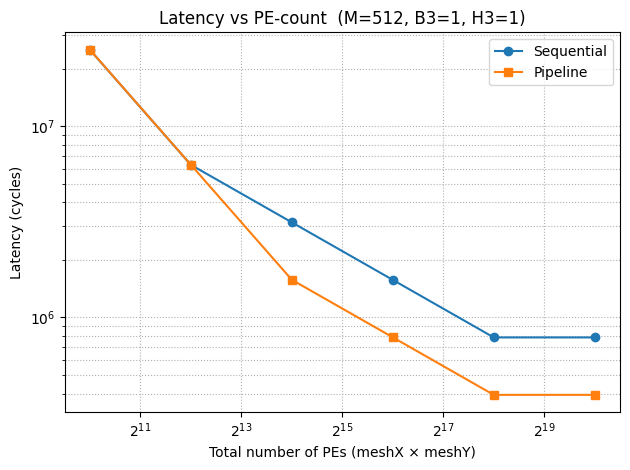

Sequential latencies : [25165824, 6291456, 3145728, 1572864, 786432, 786432]
Pipeline latencies   : [25198592, 6299648, 1574912, 787456, 393728, 393728]


In [34]:
PE_MESH_SIZES = [                          # architectures
    (32, 32),
    (64, 64),
    (128, 128),
    (256, 256),
    (512, 512),
    (1024, 1024)
]
# M_VALUES  = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]            
M_VALUES  = [512]            
B3_VALS  = [1]                           
H3_VALS  = [1]

exp1_res = run_experiments(PE_MESH_SIZES, M_VALUES, B3_VALS, H3_VALS)

plot_latency(exp1_res, 512, 1, 1)

# Experiment 2: Sequential vs Pipeline on Workload Informed Rectangular Architecture

In [35]:
PE_MESH_SIZES = [
    (16,64),
    (32,128),
    (64,256),
    (128,512),
    (128,2048),
    (128,8192)]

M_VALUES  = [512]            
B3_VALS  = [1]                           
H3_VALS  = [1]

exp2_res = run_experiments(PE_MESH_SIZES, M_VALUES, B3_VALS, H3_VALS)


=== SEQUENTIAL ===

→ PE mesh: (16, 64)
mesh=(16, 64)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=25165824  E=7.887e+16

→ PE mesh: (32, 128)
mesh=(32, 128)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=6291456  E=7.887e+16

→ PE mesh: (64, 256)
mesh=(64, 256)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=1572864  E=7.887e+16

→ PE mesh: (128, 512)
mesh=(128, 512)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=786432  E=7.887e+16

→ PE mesh: (128, 2048)
mesh=(128, 2048)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=786432  E=7.887e+16

→ PE mesh: (128, 8192)
mesh=(128, 8192)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=786432  E=7.887e+16

=== PIPELINE ===

→ PE mesh: (16, 64)
mesh=(16, 64)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=25198592  E=7.887e+16

→ PE mesh: (32, 128)
mesh=(32, 128)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=6299648  E=7.887e+16

→ PE mesh: (64, 256)
mesh=(64, 256)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=1574912  E=7.887e+16

→ PE mesh: (128, 512)
mesh=(128, 512) 

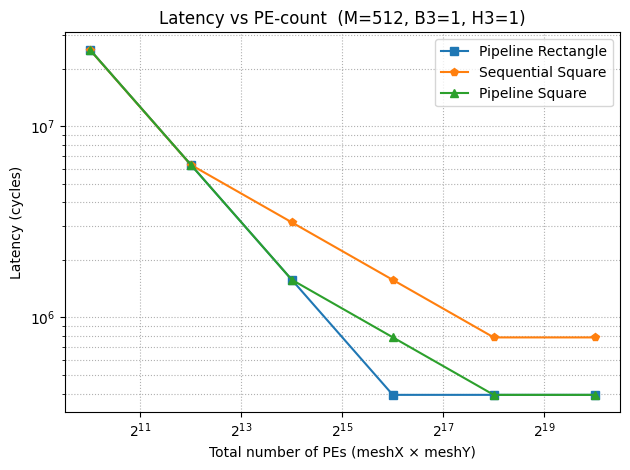

Sequential rectangular latencies : [25165824, 6291456, 1572864, 786432, 786432, 786432]
Pipeline rectangular latencies   : [25198592, 6299648, 1574912, 393728, 393728, 393728]
Sequential square latencies : [25165824, 6291456, 3145728, 1572864, 786432, 786432]
Pipeline square latencies   : [25198592, 6299648, 1574912, 787456, 393728, 393728]


In [36]:
lat_seq_retangle  = {}    
lat_pipe_rectangle = {}

lat_seq_square = {}
lat_pipe_square = {}

m_target = 512
b3_target = 1
h3_target = 1

for (mesh, M, B3, H3), res in exp2_res["sequential"].items():
    if (M, B3, H3) == (m_target, b3_target, h3_target):
        lat_seq_retangle[mesh] = res[M]["latency"]

for (mesh, M, B3, H3), res in exp2_res["pipeline"].items():
    if (M, B3, H3) == (m_target, b3_target, h3_target):
        lat_pipe_rectangle[mesh] = res[M]["latency"]

for (mesh, M, B3, H3), res in exp1_res["sequential"].items():
    if (M, B3, H3) == (m_target, b3_target, h3_target):
        lat_seq_square[mesh] = res[M]["latency"]

for (mesh, M, B3, H3), res in exp1_res["pipeline"].items():
    if (M, B3, H3) == (m_target, b3_target, h3_target):
        lat_pipe_square[mesh] = res[M]["latency"]

meshes = sorted(
    set(lat_seq_retangle) | set(lat_pipe_rectangle),
    key=lambda m: m[0] * m[1]
)

meshes_sq = sorted(
    set(lat_seq_square) | set(lat_pipe_square),
    key=lambda m: m[0] * m[1]
)

pe_counts   = [mx * my for (mx, my) in meshes]
lat_seq_r_lst = [lat_seq_retangle.get(mesh,  math.nan) for mesh in meshes]
lat_pipe_r_lst= [lat_pipe_rectangle.get(mesh, math.nan) for mesh in meshes]
lat_seq_s_lst = [lat_seq_square.get(mesh,  math.nan) for mesh in meshes_sq]
lat_pipe_s_lst= [lat_pipe_square.get(mesh, math.nan) for mesh in meshes_sq]

plt.figure()
# plt.plot(pe_counts, lat_seq_r_lst,  marker='o', label='Sequential Rectangle')
plt.plot(pe_counts, lat_pipe_r_lst, marker='s', label='Pipeline Rectangle')
plt.plot(pe_counts, lat_seq_s_lst,  marker='p', label='Sequential Square')
plt.plot(pe_counts, lat_pipe_s_lst, marker='^', label='Pipeline Square')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Total number of PEs (meshX × meshY)')
plt.ylabel('Latency (cycles)')
plt.title(f'Latency vs PE-count  (M={m_target}, B3={b3_target}, H3={h3_target})')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

print("Sequential rectangular latencies :", lat_seq_r_lst)
print("Pipeline rectangular latencies   :", lat_pipe_r_lst)
print("Sequential square latencies :", lat_seq_s_lst)
print("Pipeline square latencies   :", lat_pipe_s_lst)

# Experiment 3. Adding B3 and H3 dimensions does not improve latency

This will take a while to run. The runner.py script doesn't use pools/workers to execute jobs. 
Must change global buffer bandwidth to ~500 GB/s to get the same plots as the paper.

In [ ]:
PE_MESH_SIZES = [
    (256,256)]

M3_VALS  = [16, 32, 64, 128, 256, 512]                                     
B3_VALS  = [1, 2, 4, 8, 16, 32, 64]                                     
H3_VALS  = [1, 4, 8, 12]

exp3_res = run_experiments(PE_MESH_SIZES, M3_VALS, B3_VALS, H3_VALS)

In [ ]:
import numpy as np

mesh = (256, 256)
M_TARGET = 32
M_VALUES = [16, 32, 64, 128, 256, 512]
B3_vals = B3_VALS
H3_vals = H3_VALS

results = exp3_res

lat_seq = np.zeros((len(B3_vals), len(H3_vals)))
lat_pipe = np.zeros_like(lat_seq)
for i, B3 in enumerate(B3_vals):
    for j, H3 in enumerate(H3_vals):
        key = (mesh, M_TARGET, B3, H3)
        lat_seq[i, j] = results["sequential"][key][M_TARGET]["latency"]
        lat_pipe[i, j] = results["pipeline"][key][M_TARGET]["latency"]

lat_m = np.zeros((2, len(M_VALUES)))
for k, M in enumerate(M_VALUES):
    key = (mesh, M, 1, 1)
    lat_m[0, k] = results["sequential"][key][M]["latency"]
    lat_m[1, k] = results["pipeline"][key][M]["latency"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

# Sequential lines
for j, H3 in enumerate(H3_vals):
    ax1.plot(B3_vals, lat_seq[:, j], 'o-', linewidth=2, markersize=8, 
            alpha=0.7, label=f'H3={H3}')

ax1.set_xlabel('B3', fontsize=14)
ax1.set_ylabel('Latency (cycles)', fontsize=14)
ax1.set_title('Sequential', fontsize=16, fontweight='bold')
ax1.set_xscale('log', base=2)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Pipeline lines
for j, H3 in enumerate(H3_vals):
    ax2.plot(B3_vals, lat_pipe[:, j], 'o-', linewidth=2, markersize=8, 
            alpha=0.7, label=f'H3={H3}')

ax2.set_xlabel('B3', fontsize=14)
ax2.set_ylabel('Latency (cycles)', fontsize=14)
ax2.set_title('Pipeline', fontsize=16, fontweight='bold')
ax2.set_xscale('log', base=2)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend()

ax3.plot(M_VALUES, lat_m[0], 'o-', linewidth=3, markersize=10, 
         label='Sequential', color='blue')
ax3.plot(M_VALUES, lat_m[1], 's-', linewidth=3, markersize=10, 
         label='Pipeline', color='red')
ax3.set_xlabel('M', fontsize=14)
ax3.set_ylabel('Latency (cycles)', fontsize=14)
ax3.set_title('M-sweep (B3=1, H3=1)', fontsize=16, fontweight='bold')
ax3.set_xscale('log', base=2)
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)
ax3.legend()


plt.suptitle(f'Latency Analysis (M={M_TARGET})', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Experiment 4: Changing Buffer Size and Observing Latency

Change GlobalBuffer to depth: 16384, width: 512 in both architecture configs in current

In [32]:
M_vals4 = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
# M_values = [1, 2, 4]

# change the bandwidth of the SRAM to be 256GB/s
exp_res = run_experiments([(128, 256)], M_vals4, [1], [1])


=== SEQUENTIAL ===

→ PE mesh: (128, 256)
mesh=(128, 256)  M=1    B3=1   H3=1 
M3=  1  GB=0.0041  lat=201940991.9526701  E=6.948e+14
mesh=(128, 256)  M=2    B3=1   H3=1 
M3=  2  GB=0.0042  lat=101277695.97626305  E=6.892e+14
mesh=(128, 256)  M=4    B3=1   H3=1 
M3=  4  GB=0.0042  lat=50946047.98805952  E=6.864e+14
mesh=(128, 256)  M=8    B3=1   H3=1 
M3=  8  GB=0.0044  lat=25780223.99395776  E=6.850e+14
mesh=(128, 256)  M=16   B3=1   H3=1 
M3= 16  GB=0.0047  lat=13197311.99690688  E=6.843e+14
mesh=(128, 256)  M=32   B3=1   H3=1 
M3= 32  GB=0.0052  lat=6905855.9983814405  E=6.839e+14
mesh=(128, 256)  M=64   B3=1   H3=1 
M3= 64  GB=0.0064  lat=3760127.99911872  E=6.838e+14
mesh=(128, 256)  M=128  B3=1   H3=1 
M3=128  GB=0.0087  lat=2187263.99948736  E=6.837e+14
mesh=(128, 256)  M=256  B3=1   H3=1 
M3=256  GB=0.0133  lat=1572864  E=6.836e+14
mesh=(128, 256)  M=512  B3=1   H3=1 
M3=512  GB=0.0225  lat=1572864  E=6.836e+14

=== PIPELINE ===

→ PE mesh: (128, 256)
mesh=(128, 256)  M=1    B3

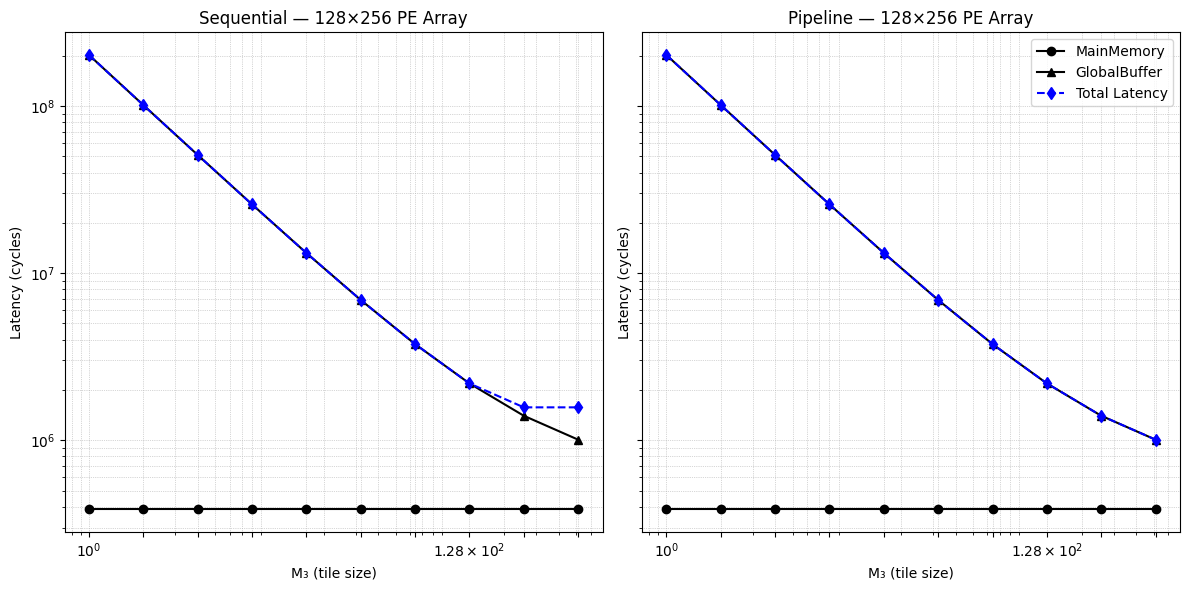

In [33]:
import matplotlib.pyplot as plt

# Only the two modes you need
modes = [
    ('Sequential', 'sequential'),
    ('Pipeline',   'pipeline'),
]

# If it’s the same PE array for both plots:
mesh = (128, 256)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

for ax, (label, mode_key) in zip(axes, modes):
    main_mem, gb_buf, total, gb_usage = [], [], [], []
    for M in M_vals4:
        stats = exp_res[mode_key][(mesh, M, 1, 1)][M]
        main_mem.append(stats['memory_latency']['MainMemory'])
        gb_buf.append(stats['memory_latency']['GlobalBuffer'])
        total.append(stats['latency'])
        gb_usage.append(stats['GB_usage'])

    ax.loglog(M_vals4, main_mem, 'k-o', label='MainMemory')
    ax.loglog(M_vals4, gb_buf,   'k-^', label='GlobalBuffer')
    ax.loglog(M_vals4, total,    'b--d', label='Total Latency')

    ax.set_title(f'{label} — {mesh[0]}×{mesh[1]} PE Array')
    # ax.set_xscale('log')
    ax.set_xticks(M_vals4)
    ax.set_xlabel('M₃ (tile size)')
    ax.set_ylabel('Latency (cycles)')
    ax.grid(which='both', linestyle=':', linewidth=0.5)

# Legend on the right-hand plot
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()
